In [1]:
import torch
print("Is CUDA available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("Current Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


Is CUDA available: True
CUDA Device Count: 1
Current Device Name: NVIDIA GeForce RTX 4050 Laptop GPU


In [2]:
paling besar tuh di model prediction

SyntaxError: invalid syntax (1443168867.py, line 1)

In [ ]:
print(f"Allocated before: {torch.cuda.memory_allocated() / 1024 ** 2:.2f} MB, Cached before: {torch.cuda.memory_reserved() / 1024 ** 2:.2f} MB")

print(f"Allocated after: {torch.cuda.memory_allocated() / 1024 ** 2:.2f} MB, Cached after: {torch.cuda.memory_reserved() / 1024 ** 2:.2f} MB")

In [1]:
from utils.dataset import DatasetFormatter
from torch_geometric.loader import DataLoader
import torch.multiprocessing as mp
from utils.noise import get_velocity_noise
from simulator import Simulator
import torch
from utils.utils import NodeType

torch.cuda.empty_cache()

#training parameters
noise_std=0
learning_rate = 1e-3
max_epoch = 100
batch_size = 1
open_tran_num = 5
accumulations_step = 3

#model parameters
node_attr_size = 3      # ini samain dengan node attr size yang udh ada one hot encoding di simulator.py
edge_attr_size = 1      # Matches dummy edge features
latent_dim_size = 16    # Latent space dimension
message_passing_num = 3 # Number of message passing steps
print_batch = 1
save_batch = 20

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
model = Simulator(latent_dim_size=latent_dim_size, 
                  message_passing_num=message_passing_num, 
                  node_input_size=node_attr_size, 
                  edge_input_size=edge_attr_size, 
                  device=device)
model.load_checkpoint()
optimizer= torch.optim.Adam(model.parameters(), lr=learning_rate)

if __name__ == '__main__':
    # mp.set_start_method('spawn')
    for i in range(max_epoch):
        dataset = DatasetFormatter(max_epochs=max_epoch, open_tra_num=open_tran_num, dataset_dir="dataset_split")
        train_loader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0)
        
        for batch_index, graph in enumerate(train_loader):
            
            # print(f"Allocated before: {torch.cuda.memory_allocated() / 1024 ** 2:.2f} MB")
            # print(f"Cached before: {torch.cuda.memory_reserved() / 1024 ** 2:.2f} MB")
            graph = graph.cuda()
            # print(f"Allocated after: {torch.cuda.memory_allocated() / 1024 ** 2:.2f} MB")
            # print(f"Cached after: {torch.cuda.memory_reserved() / 1024 ** 2:.2f} MB")
            
            node_type = graph.x[:, 0]
            velocity_sequence_noise = get_velocity_noise(graph, noise_std=noise_std)
            
            predicted_acc, target_acc = model(graph, velocity_sequence_noise) # only taking the velocity attributes
            mask = torch.logical_or(node_type==NodeType.NORMAL, node_type==NodeType.FARFIELD) # only taking the fluid nodes, not the solid/inlet/farfield
                                                                                                                
            errors = ((predicted_acc - target_acc)**2) # for x and y vel without solid body
            loss = torch.mean(errors[mask])

            # grad accumu
            # if batch_index%accumulations_step == 0:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_index % print_batch == 0:
                print('epoch %d :batch %d [loss %.2e]'%(i, batch_index, loss.item()))

            if batch_index % save_batch == 0:
                model.save_checkpoint()

c:\Users\Yuno\anaconda3\envs\gmn-venv\lib\site-packages\torch_cluster\nearest.py:3: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.1)
  import scipy.cluster


Simulator model initialized
Simulator model loaded checkpoint checkpoint/simulator.pth
Dataset dataset_split\train.h5 Initilized
epoch 0 :batch 0 [loss 5.87e+00]
Simulator model saved at checkpoint/simulator.pth
epoch 0 :batch 1 [loss 9.18e-01]
epoch 0 :batch 2 [loss 1.43e+00]
epoch 0 :batch 3 [loss 1.05e+00]
epoch 0 :batch 4 [loss 7.39e-01]
epoch 0 :batch 5 [loss 6.79e-01]
epoch 0 :batch 6 [loss 7.13e-01]
epoch 0 :batch 7 [loss 7.31e-01]
epoch 0 :batch 8 [loss 7.52e-01]
epoch 0 :batch 9 [loss 7.47e-01]
epoch 0 :batch 10 [loss 7.56e-01]
epoch 0 :batch 11 [loss 7.42e-01]
epoch 0 :batch 12 [loss 7.28e-01]
epoch 0 :batch 13 [loss 7.25e-01]
epoch 0 :batch 14 [loss 7.19e-01]
epoch 0 :batch 15 [loss 7.02e-01]
epoch 0 :batch 16 [loss 7.06e-01]
epoch 0 :batch 17 [loss 7.02e-01]
epoch 0 :batch 18 [loss 6.86e-01]
epoch 0 :batch 19 [loss 6.84e-01]
epoch 0 :batch 20 [loss 6.94e-01]
Simulator model saved at checkpoint/simulator.pth
epoch 0 :batch 21 [loss 6.86e-01]
epoch 0 :batch 22 [loss 6.91e-01]

KeyboardInterrupt: 

In [1]:
from utils.dataset import DatasetFormatter
from torch_geometric.loader import DataLoader
import torch.multiprocessing as mp
from utils.noise import get_velocity_noise
from simulator import Simulator
import torch
from utils.utils import NodeType

# Hyperparameters
noise_std = 2e-2
node_attr_size = 6
edge_attr_size = 1
latent_dim_size = 18
message_passing_num = 3
learning_rate = 3e-4
print_batch = 1
save_batch = 20
max_grad_norm = 1.0
batch_size = 1

# Device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# Initialize model and optimizer
model = Simulator(
    latent_dim_size=latent_dim_size,
    message_passing_num=message_passing_num,
    node_input_size=node_attr_size,
    edge_input_size=edge_attr_size,
    device=device
)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training loop
if __name__ == '__main__':
    dataset = DatasetFormatter(max_epochs=10, dataset_dir="dataset_split")
    train_loader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0)

    for batch_index, graph_batch in enumerate(train_loader):

        # Move batch to device
        graph_batch = graph_batch.cuda()
        node_type = graph_batch.x[:, 0]

        # Add noise to velocities
        velocity_sequence_noise = get_velocity_noise(graph_batch, noise_std=noise_std)

        # Forward pass
        predicted_acc, target_acc = model(graph_batch, velocity_sequence_noise)

        # Compute loss
        mask = torch.logical_or(node_type == NodeType.NORMAL, node_type == NodeType.FARFIELD)
        errors = (predicted_acc - target_acc) ** 2
        loss = torch.sum(errors[mask]) / mask.sum()  # Normalize by active nodes

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        # Optimizer step
        optimizer.step()

        # Log loss
        # if batch_index % print_batch == 0:
        print('Batch %d [loss %.2e]' % (batch_index, loss.item()))

        # Save model checkpoint
        if batch_index % save_batch == 0:
            model.save_checkpoint()

        # Update learning rate scheduler
        scheduler.step(loss.item())

    print("Training complete.")

c:\Users\Yuno\anaconda3\envs\gmn-venv\lib\site-packages\torch_cluster\nearest.py:3: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.1)
  import scipy.cluster


Simulator model initialized
Dataset dataset_split\train.h5 Initilized
selected trajectory: 64
target trajectory: 65
Batch 0 [loss 2.07e+00]
Simulator model saved at checkpoint/simulator.pth
selected trajectory: 26
target trajectory: 27
Batch 1 [loss 2.06e+00]
selected trajectory: 36
target trajectory: 37
Batch 2 [loss 2.07e+00]
selected trajectory: 53
target trajectory: 54
Batch 3 [loss 2.07e+00]
selected trajectory: 49
target trajectory: 50
Batch 4 [loss 2.05e+00]
selected trajectory: 7
target trajectory: 8
Batch 5 [loss 2.05e+00]
selected trajectory: 66
target trajectory: 67
Batch 6 [loss 2.06e+00]
selected trajectory: 18
target trajectory: 19
Batch 7 [loss 2.04e+00]
selected trajectory: 10
target trajectory: 11
Batch 8 [loss 2.06e+00]
selected trajectory: 4
target trajectory: 5
Batch 9 [loss 2.05e+00]
selected trajectory: 3
target trajectory: 4
Batch 10 [loss 2.06e+00]
selected trajectory: 67
target trajectory: 68
Batch 11 [loss 2.05e+00]
selected trajectory: 57
target trajectory: 5

KeyboardInterrupt: 

# TODO: 

- one hot encoding masih belum bener
- buat rollout

In [6]:
from simulator import Simulator
import torch
from utils.dataset import DatasetFormatter, DatasetFormat
from torch_geometric.loader.dataloader import DataLoader
from utils.noise import get_velocity_noise

torch.cuda.empty_cache()
device = "cuda:0"
dataset = DatasetFormatter(max_epochs=10, dataset_dir="dataset_split", split='val', device=device)
train_loader = DataLoader(dataset=dataset, batch_size=1, num_workers=0)

DatasetFormat(open_trajectory=5)


dataset_split\val.h5
Dataset dataset_split\val.h5 Initilized


In [ ]:
from simulator import Simulator
import torch
from utils.dataset import DatasetFormatter
from torch_geometric.loader.dataloader import DataLoader
import numpy as np

device = "cuda:0"
dataset = DatasetFormatter(max_epochs=10, 
                           dataset_dir="dataset_split", 
                           split= 'val',
                           open_tra_num=5, 
                           device=device)

train_loader = DataLoader(dataset=dataset, batch_size=1, num_workers=0)

noise_std=0

# Define the model parameters
node_attr_size = 3      # ini samain dengan node attr size yang udh ada one hot encoding di simulator.py
edge_attr_size = 1      # Matches dummy edge features
latent_dim_size = 16    # Latent space dimension
message_passing_num = 3 # Number of message passing steps
print_batch = 1
save_batch = 20

model = Simulator(latent_dim_size=latent_dim_size, 
                  message_passing_num=message_passing_num, 
                  node_input_size=node_attr_size, 
                  edge_input_size=edge_attr_size, 
                  device=device, 
                  training=True)

model.load_checkpoint('pretrained.pth')

predicts = []
GT = []
errors =[]
for batch_index, graph in enumerate(train_loader):
    torch.cuda.empty_cache()
    #x vel, y vel, 4 label
    graph.cuda()

    print(f"Predict batch: {batch_index}")
    predict, ground_truth = model(graph)
    
    node_type = graph.x[:, 0].detach().cpu()
    mask = torch.logical_or(node_type == 0, node_type == 1)
    predicts.append(predict.detach().cpu().numpy())
    GT.append(ground_truth.detach().cpu().numpy())

    error = np.sqrt((GT[0][mask] - predicts[0][mask])**2)
    errors.append(error)
    


c:\Users\Yuno\anaconda3\envs\gmn-venv\lib\site-packages\torch_cluster\nearest.py:3: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.1)
  import scipy.cluster


Dataset dataset_split\val.h5 Initilized
Simulator model initialized
Simulator model loaded checkpoint pretrained.pth
Predict batch: 0
Predict batch: 1


OutOfMemoryError: CUDA out of memory. Tried to allocate 178.00 MiB. GPU 0 has a total capacty of 6.00 GiB of which 0 bytes is free. Of the allocated memory 8.32 GiB is allocated by PyTorch, and 86.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

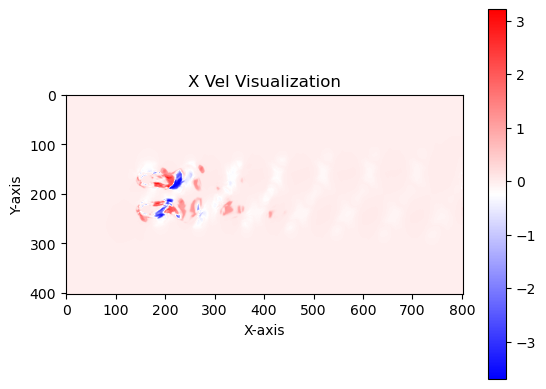

In [4]:
import matplotlib.pyplot as plt
predict_res = predicts[0][:, 0].reshape(402, 802) # x and y velocity
plt.imshow(predict_res, cmap = 'bwr')
plt.colorbar()  # Add the color scale
plt.title("X Vel Visualization")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

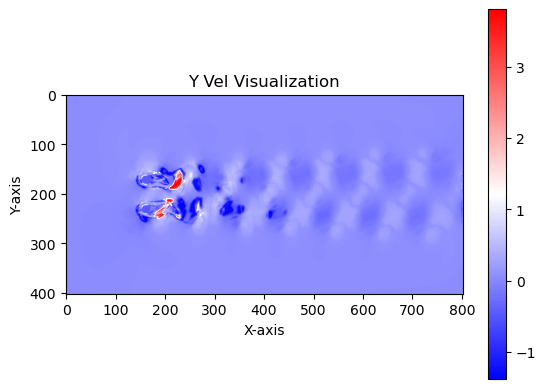

In [5]:
import matplotlib.pyplot as plt
predict_res = predicts[0][:, 1].reshape(402, 802) # x and y velocity
plt.imshow(predict_res, cmap = 'bwr')
plt.colorbar()  # Add the color scale
plt.title("Y Vel Visualization")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

In [6]:
errors[:, 0].cpu().detach().numpy()

array([0.00088121, 0.00018665, 0.00018551, ..., 0.00018552, 0.00018682,
       0.00087887], dtype=float32)

In [9]:
errors = np.sqrt((GT[0] - predicts[0])**2)
np.mean(errors)

0.4178501

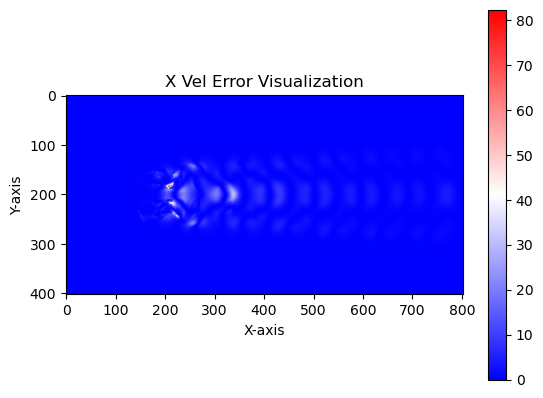

In [7]:
import matplotlib.pyplot as plt
errors_res = errors[:, 0].reshape(402, 802) # x and y velocity
plt.imshow(errors_res, cmap = 'bwr')
plt.colorbar()  # Add the color scale
plt.title("X Vel Error Visualization")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

In [14]:
import matplotlib.pyplot as plt
errors_res = errors[:, 1].reshape(402, 802) # x and y velocity
plt.imshow(errors_res.cpu().detach().numpy(), cmap = 'bwr')
plt.colorbar()  # Add the color scale
plt.title("Y Vel Error Visualization")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()